In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')



/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


#Data

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)


In [ ]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length



In [ ]:

train_data.posts,train_length=clear_text(train_data)

test_data.posts,test_length=clear_text(test_data)


100%|██████████| 1735/1735 [00:02<00:00, 730.75it/s]


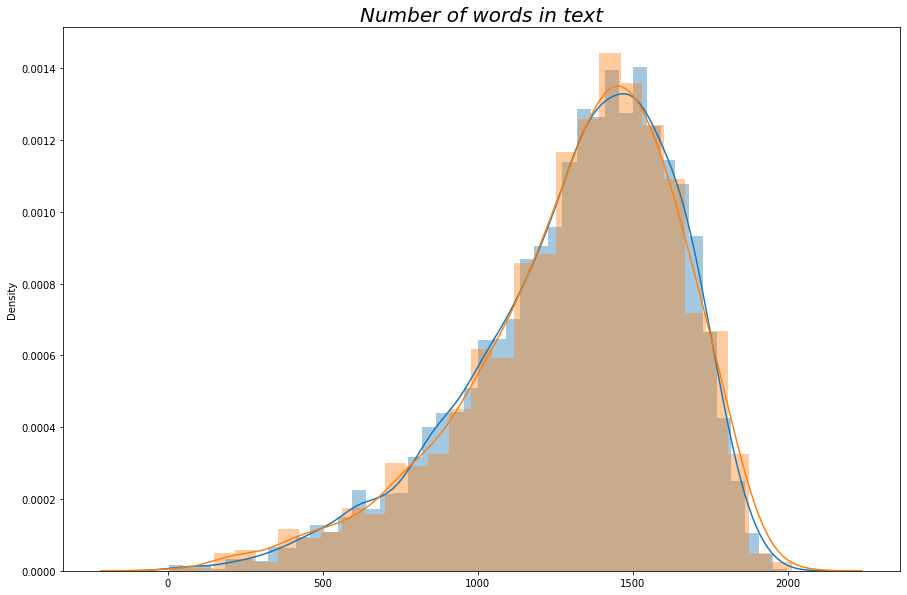

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [ ]:
px.pie(train_data,names='type',title='Personality type',hole=0.3).show()

#Tokenizing words

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [ ]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x7fca61fd3cd0>)

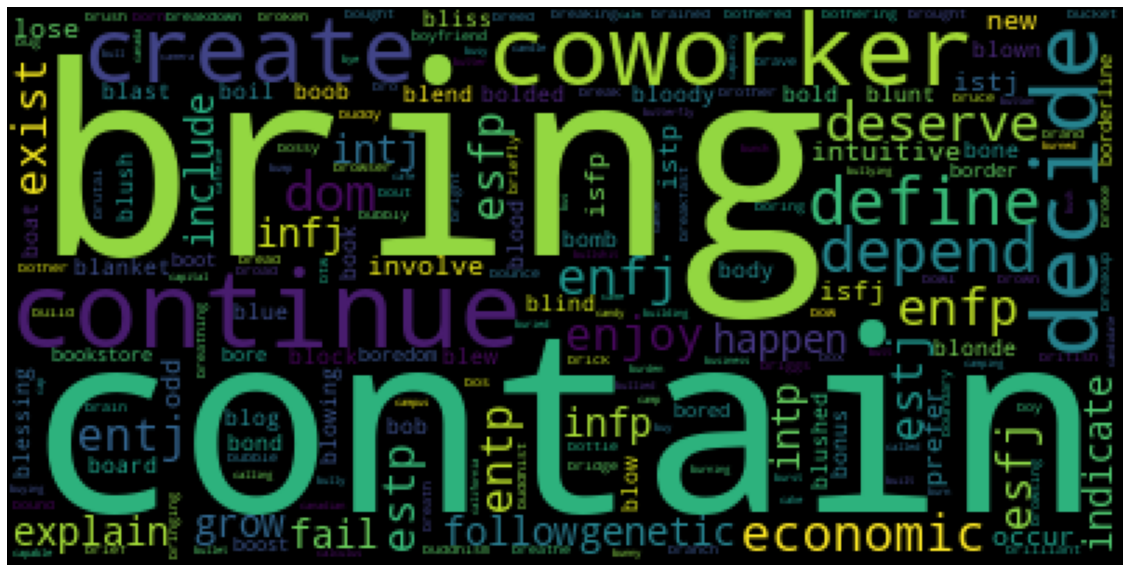

In [ ]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [ ]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [ ]:
train_post.shape

(6940, 5000)

In [ ]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

#Model selection

In [ ]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.80      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.74      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1466
        INTJ       0.73      0.80      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.24      0.38       133
        ISFP       0.86      0.25      0.39       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.51      0.64       270

    accuracy                           0.72      

In [ ]:
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))


In [ ]:
models_accuracy = {}

In [ ]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

#Linear Support Vector classifier

In [ ]:
model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)


LinearSVC(C=0.1)

In [ ]:


print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))



train classification report 
                precision    recall  f1-score   support

        ENFJ       0.89      0.46      0.61       152
        ENFP       0.85      0.76      0.80       540
        ENTJ       0.92      0.64      0.76       185
        ENTP       0.84      0.82      0.83       548
        ESFJ       0.91      0.30      0.45        33
        ESFP       1.00      0.13      0.23        38
        ESTJ       1.00      0.26      0.41        31
        ESTP       0.92      0.48      0.63        71
        INFJ       0.82      0.86      0.84      1176
        INFP       0.77      0.93      0.84      1466
        INTJ       0.83      0.85      0.84       873
        INTP       0.81      0.90      0.85      1043
        ISFJ       0.92      0.67      0.77       133
        ISFP       0.89      0.58      0.70       217
        ISTJ       0.88      0.66      0.76       164
        ISTP       0.90      0.82      0.86       270

    accuracy                           0.82      

In [ ]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

#Support Vector classifier

In [ ]:
model_svc=SVC()
model_svc.fit(train_post,train_target)

SVC()

In [ ]:
print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))


train classification report 
                precision    recall  f1-score   support

        ENFJ       0.97      0.86      0.91       152
        ENFP       0.96      0.95      0.95       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.95      0.96      0.95       548
        ESFJ       1.00      0.58      0.73        33
        ESFP       1.00      0.37      0.54        38
        ESTJ       1.00      0.52      0.68        31
        ESTP       1.00      0.82      0.90        71
        INFJ       0.95      0.97      0.96      1176
        INFP       0.93      0.98      0.95      1466
        INTJ       0.96      0.96      0.96       873
        INTP       0.94      0.97      0.96      1043
        ISFJ       1.00      0.89      0.94       133
        ISFP       0.97      0.90      0.94       217
        ISTJ       0.94      0.92      0.93       164
        ISTP       0.97      0.94      0.95       270

    accuracy                           0.95      

In [ ]:
models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))

#Multinomial Naive Bayes

In [ ]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [ ]:
print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.89      0.01      0.03       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.91      0.05      0.10       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.52      0.62      0.56      1176
        INFP       0.35      0.94      0.51      1466
        INTJ       0.78      0.42      0.54       873
        INTP       0.58      0.63      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       0.00      0.00      0.00       270

    accuracy                           0.46      

In [ ]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

#Decision Tree Classifier

In [ ]:
model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

DecisionTreeClassifier(max_depth=14)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))


train classification report 
                precision    recall  f1-score   support

        ENFJ       0.77      0.57      0.65       152
        ENFP       0.87      0.82      0.84       540
        ENTJ       0.91      0.66      0.77       185
        ENTP       0.94      0.76      0.84       548
        ESFJ       0.93      0.39      0.55        33
        ESFP       0.91      0.26      0.41        38
        ESTJ       0.85      0.35      0.50        31
        ESTP       0.82      0.45      0.58        71
        INFJ       0.80      0.86      0.83      1176
        INFP       0.63      0.93      0.75      1466
        INTJ       0.87      0.77      0.82       873
        INTP       0.87      0.82      0.84      1043
        ISFJ       0.98      0.39      0.56       133
        ISFP       0.97      0.64      0.77       217
        ISTJ       0.96      0.56      0.71       164
        ISTP       0.98      0.69      0.81       270

    accuracy                           0.79      

In [ ]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))


#Random Forest Classifier

In [ ]:
model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(train_post,train_target)

RandomForestClassifier(max_depth=10)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_forest.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_forest.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.05      0.09       152
        ENFP       0.99      0.40      0.57       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.99      0.51      0.67       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.80      0.82      0.81      1176
        INFP       0.45      0.99      0.62      1466
        INTJ       0.89      0.74      0.81       873
        INTP       0.79      0.87      0.83      1043
        ISFJ       1.00      0.07      0.13       133
        ISFP       1.00      0.07      0.13       217
        ISTJ       1.00      0.05      0.09       164
        ISTP       1.00      0.28      0.44       270

    accuracy                           0.66      

In [ ]:
models_accuracy['Random Forest Classifier']=accuracy_score(test_target,model_forest.predict(test_post))


#Accuracy of all ML model


In [ ]:
models_accuracy

{'Decision Tree classifier': 0.500864553314121,
 'Linear Support Vector classifier': 0.6628242074927954,
 'Multinomial Naive Bayes': 0.37809798270893374,
 'Random Forest Classifier': 0.4731988472622478,
 'Support Vector classifier': 0.6478386167146974,
 'logistic regression': 0.6282420749279539}

In [ ]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])


In [ ]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,Linear Support Vector classifier,0.662824
1,Support Vector classifier,0.647839
2,logistic regression,0.628242
3,Decision Tree classifier,0.500865
4,Random Forest Classifier,0.473199
5,Multinomial Naive Bayes,0.378098


#LSTM

In [ ]:
pip install keras

In [ ]:
pip install tensorflow

     |████████████████████████████████| 462 kB 9.2 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

%matplotlib inline
from nltk import tokenize

import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Model


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:

import numpy as np

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer() 
cachedStopWords = stopwords.words("english")

In [ ]:
def cleaning_data(data, remove_stop_words=True):
    list_posts = []
    i=0   
    for row in data.iterrows():
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', posts) #remove urls
        temp = re.sub("[^a-zA-Z.]", " ", temp) #remove all punctuations except fullstops.
        temp = re.sub(' +', ' ', temp).lower() 
        temp=re.sub(r'\.+', ".", temp) #remove multiple fullstops.
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
        list_posts.append(temp)

    text = np.array(list_posts)
    return text

In [ ]:
clean_text = cleaning_data(data, remove_stop_words=True)
data['clean_text']=clean_text
data = data[['clean_text', 'type']]

In [ ]:
data.head()

,clean_text,type
0,enfp intj moment sportscenter top ten play pr...,INFJ
1,finding lack post alarming. sex boring positi...,ENTP
2,good one course say know blessing curse. abso...,INTP
3,dear intp enjoyed conversation day. esoteric ...,INTJ
4,fired. another silly misconception. approachi...,ENTJ


In [ ]:
types=data['type']
text=data['clean_text']
tps=data.groupby('type')

In [ ]:

max_len=200   # maximum words in a sentence
VAL_SPLIT = 0.2

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
max_features = len(tokenizer.word_index) + 1 # maximum number of unique words


input_sequences = []
for line in (data):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)



In [ ]:
max_seq_length = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_seq_length, padding='pre'))

xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=max_features, dtype='float64')

x_val = xs * VAL_SPLIT
y_val = ys * VAL_SPLIT



In [ ]:
ys

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from tensorflow.keras import layers

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length = max_seq_length - 1))


model.add(tf.keras.layers.Conv1D(64, (1), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv1D(64, (1), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 


#model.add(LSTM(64, return_sequences=True)) 

#model.add(layers.SimpleRNN(128))


#model.add(layers.SimpleRNN(128))
#model.add(layers.LSTM(64))

model.add(Bidirectional(LSTM(180)))

model.add(Dense(max_features, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(xs, ys, epochs = 500, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 11.4457 - acc: 0.0000e+00 - val_loss: 2.2887 - val_acc: 1.0000
Epoch 2/500
1/1 [==============================] - 0s 266ms/step - loss: 11.4427 - acc: 1.0000 - val_loss: 2.2882 - val_acc: 1.0000
Epoch 3/500
1/1 [==============================] - 0s 235ms/step - loss: 11.4407 - acc: 1.0000 - val_loss: 2.2877 - val_acc: 1.0000
Epoch 4/500
1/1 [==============================] - 0s 251ms/step - loss: 11.4379 - acc: 1.0000 - val_loss: 2.2872 - val_acc: 1.0000
Epoch 5/500
1/1 [==============================] - 0s 244ms/step - loss: 11.4349 - acc: 1.0000 - val_loss: 2.2866 - val_acc: 1.0000
Epoch 6/500
1/1 [==============================] - 0s 241ms/step - loss: 11.4306 - acc: 1.0000 - val_loss: 2.2860 - val_acc: 1.0000
Epoch 7/500
1/1 [==============================] - 0s 242ms/step - loss: 11.4266 - acc: 1.0000 - val_loss: 2.2854 - val_acc: 1.0000
Epoch 8/500
1/1 [==============================] - 0s 244ms/step - loss: 11

In [ ]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 1, 64)             5984896   
                                                                 
 conv1d_128 (Conv1D)         (None, 1, 64)             4160      
                                                                 
 conv1d_129 (Conv1D)         (None, 1, 64)             4160      
                                                                 
 dropout_70 (Dropout)        (None, 1, 64)             0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 360)              352800    
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 93514)             33758554  
                                                     

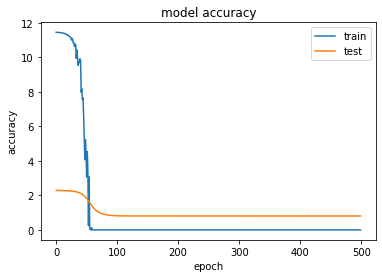

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
model.evaluate(x_val, y_val, verbose=0)

[0.8060407638549805, 1.0]

In [ ]:
model.predict(x_val)

array([[1.0473517e-05, 1.0479282e-05, 1.0505803e-05, ..., 1.0580444e-05,
        1.0627498e-05, 1.0374009e-05]], dtype=float32)

In [ ]:
pred = model.predict(x_val) 
pred = np.argmax(pred, axis = 1)[:5] 
label = np.argmax(y_val,axis = 1)[:5] 

print(pred) 
print(label)

[784]
[784]


In [ ]:
model.save('mbti_rnn_80%.h5')


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Diffrent Method

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from nltk.corpus import stopwords

def preprocess_inputs(df):
    
    texts = df['posts'].copy()
    labels = df['type'].copy()
    
    # Process text data
    stop_words = stopwords.words('english')
    
    texts = [text.lower() for text in texts]
    texts = [text.split() for text in texts]
    texts = [[word.strip() for word in text] for text in texts]
    texts = [[word for word in text if word not in stop_words] for text in texts]
    
    vocab_length = 10000
    
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    
    texts = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(text) for text in texts])
    
    texts = pad_sequences(texts, maxlen=max_seq_length, padding='post')
    
    # Process label data
    label_values = [
        'INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'
    ]
    
    label_mapping = {label: np.int(label[0] == 'E') for label in label_values}
    
    labels = labels.replace(label_mapping)
    labels = np.array(labels)
    
    return texts, labels, max_seq_length, vocab_length, label_mapping



In [ ]:
texts, labels, max_seq_length, vocab_length, label_mapping = preprocess_inputs(data)


In [ ]:
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, train_size=0.7, random_state=123)


In [ ]:
import tensorflow as tf

embedding_dim = 512

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(
        units=256,
        return_sequences=True
    )
)(embedding)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=2,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True)
    ]
)



Epoch 1/2
152/152 [==============================] - 1879s 12s/step - loss: 0.5247 - accuracy: 0.7743 - auc: 0.6499 - val_loss: 0.4409 - val_accuracy: 0.8091 - val_auc: 0.7986
Epoch 2/2
152/152 [==============================] - 1763s 12s/step - loss: 0.0405 - accuracy: 0.9916 - auc: 0.9993 - val_loss: 0.5234 - val_accuracy: 0.7975 - val_auc: 0.7953


In [ ]:
model.evaluate(texts_test, labels_test)

82/82 [==============================] - 204s 2s/step - loss: 0.5217 - accuracy: 0.8045 - auc: 0.7839


[0.521653950214386, 0.8044564127922058, 0.7839093208312988]